In [86]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [87]:
TRAIN_IMG_DIR = './train_img/'
TRAIN_MASK_DIR = './train_lab/'

TEST_IMG_DIR = './test_img/'
TEST_MASK_DIR = './test_lab/'

In [88]:
train_images = sorted(glob(os.path.join(TRAIN_IMG_DIR, "*.jpg")))
train_masks  = sorted(glob(os.path.join(TRAIN_MASK_DIR, "*.png")))

test_images  = sorted(glob(os.path.join(TEST_IMG_DIR, "*.jpg")))
test_masks   = sorted(glob(os.path.join(TEST_MASK_DIR, "*.png")))

print("Train size:", len(train_images))
print("Test size :", len(test_images))

Train size: 300
Test size : 237


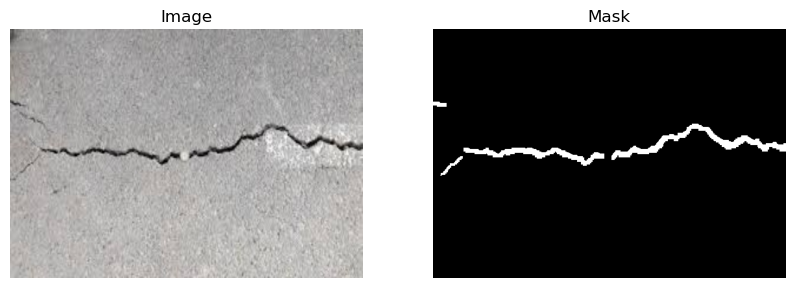

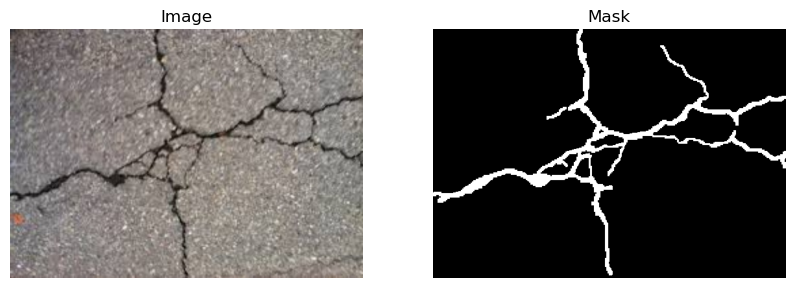

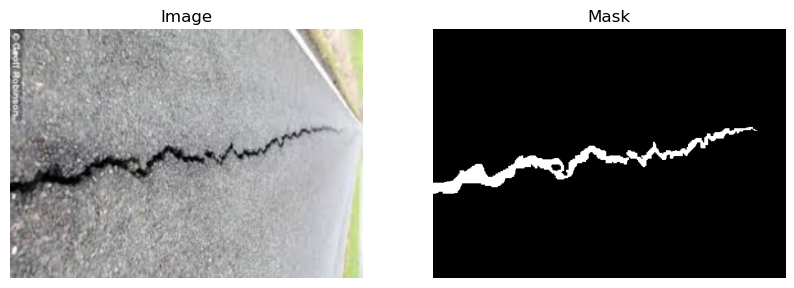

In [89]:
def show_image_mask(image_path, mask_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis("off")
    plt.show()

# Show a few samples
for i in range(3):
    show_image_mask(train_images[i], train_masks[i])

In [90]:
# Define the target dimensions; CNNs require all input images to be the same size
IMG_SIZE = (128, 128)

def preprocess(img_path, mask_path):
    # 1. Process the raw color image (X)
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalization: converts pixel values from [0-255] to [0-1.0]

    # 2. Process the label/mask (y)
    # Load in grayscale because masks only need 1 color channel (crack vs. no crack)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMG_SIZE)
    mask = mask / 255.0  # Normalization: converts to 0.0 (background) and 1.0 (crack)
    
    # Add a channel dimension: changes shape from (128, 128) to (128, 128, 1)
    # Most deep learning libraries (TensorFlow/Keras) expect 3D tensors for images
    mask = np.expand_dims(mask, axis=-1)

    return img, mask

# Create the dataset arrays
# This line pairs each image path with its mask path and runs the function for all of them
X, y = zip(*[preprocess(i, m) for i, m in zip(train_images, train_masks)])

# Convert the lists into NumPy arrays for high-performance computing/GPU training
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape  :", X_val.shape, y_val.shape)

Train shape: (240, 128, 128, 3) (240, 128, 128, 1)
Val shape  : (60, 128, 128, 3) (60, 128, 128, 1)


In [102]:
def build_unet(input_shape=(128, 128, 3)):
    # Define the input layer with the shape (Height, Width, Channels)
    inputs = layers.Input(shape=input_shape)

    # --- ENCODER (Contracting Path) ---
    # The goal here is to capture "context." As we go deeper, the spatial 
    # dimensions (128->64->32) shrink, but the number of features (16->32->64) increases.
    
    # Block 1: Extracts simple features like edges
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1) # Reduces image size by half

    # Block 2: Extracts more complex shapes
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Block 3: Captures deep semantic information
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    # --- BOTTLENECK ---
    # The lowest point of the 'U'. It contains the most compressed representation of the image.
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(b)

    # --- DECODER (Expansive Path) ---
    # The goal here is "localization." We resize the image back to its original size 
    # to pinpoint exactly where the crack is.

    # Block 4: Up-sampling + Skip Connection
    u1 = layers.UpSampling2D()(b)
    # Concatenate combines the high-res features from the encoder (c3) 
    # with the up-sampled features to help the model recover fine crack details.
    u1 = layers.Concatenate()([u1, c3]) 
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)

    # Block 5: Getting larger...
    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2]) # Skip connection from Block 2
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(c5)

    # Block 6: Returning to original 128x128 resolution
    u3 = layers.UpSampling2D()(c5)
    u3 = layers.Concatenate()([u3, c1]) # Skip connection from Block 1
    c6 = layers.Conv2D(16, 3, activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(16, 3, activation='relu', padding='same')(c6)

    # --- OUTPUT LAYER ---
    # 1 filter because we want a single-channel mask (crack vs no-crack).
    # 'sigmoid' ensures every pixel is a probability between 0 and 1.
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c6)

    model = models.Model(inputs, outputs)
    return model

In [103]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_state(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)


In [104]:
def get_metrics(y_test_pred):
    y_pred_bin = (y_test_pred > 0.5).astype(int)

    acc = tf.keras.metrics.BinaryAccuracy()
    iou = tf.keras.metrics.BinaryIoU(threshold=0.5)
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    
    acc.update_state(y_test, y_pred_bin)
    iou.update_state(y_test, y_test_pred)
    precision.update_state(y_test, y_pred_bin)
    recall.update_state(y_test, y_pred_bin)
    
    f1 = 2 * precision.result() * recall.result() / (
        precision.result() + recall.result() + tf.keras.backend.epsilon()
    )
    
    print(f'Accuracy: {acc.result().numpy()}' , f'IoU: {iou.result().numpy()}' , f'F1 Score {f1.numpy()}')


In [105]:
model = build_unet()
model.compile(
    optimizer='adam',
    loss=bce_dice_loss, 
    metrics=[
        'accuracy',
        tf.keras.metrics.BinaryIoU(threshold=0.5),
        F1Score()
    ]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step - accuracy: 0.9054 - binary_io_u_11: 0.4620 - f1_score: 0.0308 - loss: 1.2875 - val_accuracy: 0.9706 - val_binary_io_u_11: 0.4872 - val_f1_score: 0.0000e+00 - val_loss: 1.1387
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.9684 - binary_io_u_11: 0.4863 - f1_score: 0.0000e+00 - loss: 1.1131 - val_accuracy: 0.9706 - val_binary_io_u_11: 0.4872 - val_f1_score: 0.0000e+00 - val_loss: 1.0619
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.9684 - binary_io_u_11: 0.4863 - f1_score: 0.0000e+00 - loss: 0.9675 - val_accuracy: 0.9706 - val_binary_io_u_11: 0.4872 - val_f1_score: 0.0000e+00 - val_loss: 0.8054
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.9703 - binary_io_u_11: 0.5345 - f1_score: 0.1657 - loss: 0.8007 - val_accuracy: 0.9794 - val_binary_io_u_11: 0.6942 - val_f1_score: 0.5617 - val_loss: 0.6832
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.9713 - binary_io_u

In [106]:
y_val_pred = model.predict(X_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


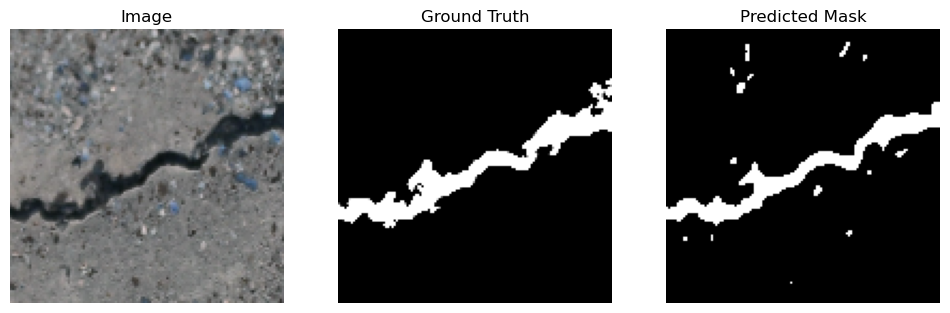

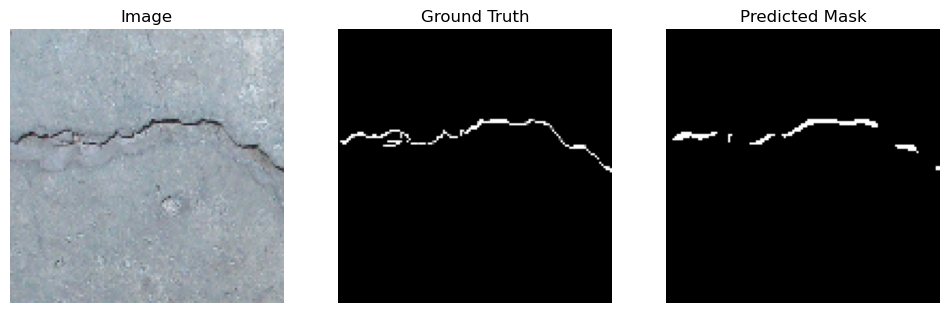

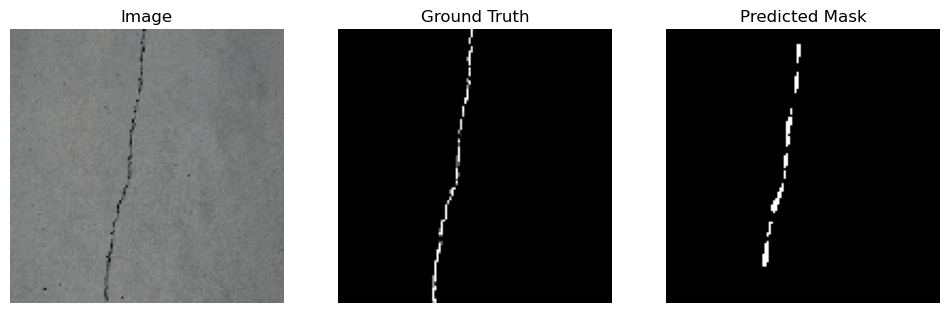

In [107]:
def visualize_prediction(idx):
    img = X_val[idx]
    true_mask = y_val[idx].squeeze()
    pred_mask = y_val_pred[idx].squeeze()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask > 0.5, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Try for a few validation samples
for i in range(3):
    visualize_prediction(i)

In [108]:
# Preprocess test set
X_test, y_test = zip(*[preprocess(i, m) for i, m in zip(test_images, test_masks)])
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [109]:
# Predict on test set
y_test_pred = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step


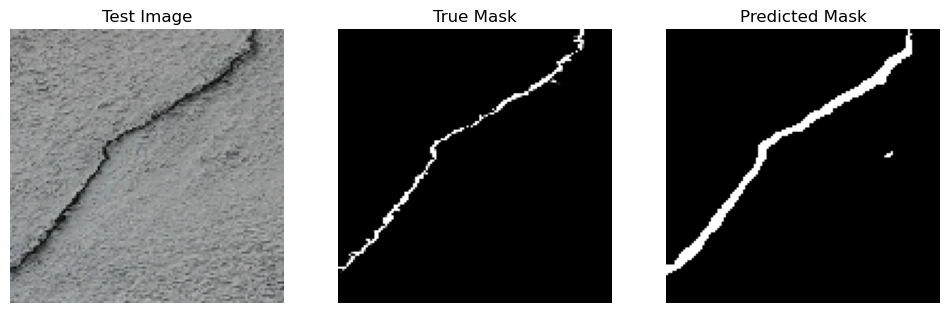

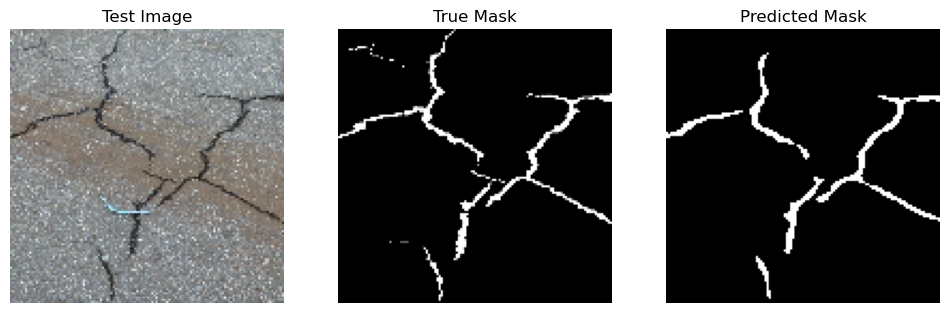

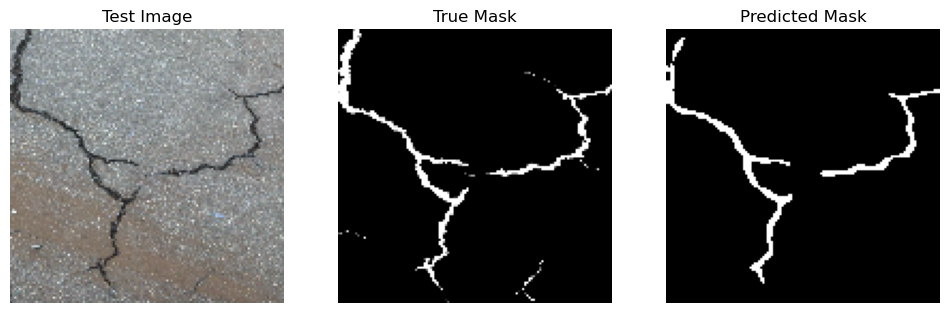

In [110]:
def visualize_test(idx):
    img = X_test[idx]
    true_mask = y_test[idx].squeeze()
    pred_mask = y_test_pred[idx].squeeze()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Test Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask > 0.5, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# View test samples
for i in range(3):
    visualize_test(i)


In [111]:
get_metrics(y_test_pred)

Accuracy: 0.9769526720046997 IoU: 0.7950338125228882 F1 Score 0.7698675394058228


In [76]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, Concatenate, Conv2D

In [77]:
def build_mobilenet_unet(input_shape=(128, 128, 3)):
    # Load pretrained MobileNetV2 as encoder
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Select layer outputs for skip connections
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4 (deepest)
    ]
    layers_output = [base_model.get_layer(name).output for name in layer_names]

    down_stack = Model(inputs=base_model.input, outputs=layers_output)
    down_stack.trainable = False  # Freeze encoder

    # Decoder
    inputs = Input(shape=input_shape)
    skips = down_stack(inputs)
    x = skips[-1]  # start from the deepest encoder layer

    up_filters = [512, 256, 128, 64, 32]

    for i in range(1, len(skips)):
        x = Conv2DTranspose(up_filters[i], 3, strides=2, padding='same')(x)
        x = Concatenate()([x, skips[-i - 1]])

    # Final upsampling from 64x64 → 128x128
    x = Conv2DTranspose(16, 3, strides=2, padding='same')(x)
    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

In [78]:
model = build_mobilenet_unet()
model.compile(
    optimizer='adam',
    loss=bce_dice_loss, 
    metrics=[
        'accuracy',
        tf.keras.metrics.BinaryIoU(threshold=0.5),
        F1Score()
    ]
)

In [79]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("mobilenet_unet_best_model.keras", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9115 - binary_io_u_7: 0.4698 - f1_score: 0.0499 - loss: 1.2614 - val_accuracy: 0.9699 - val_binary_io_u_7: 0.5137 - val_f1_score: 0.0991 - val_loss: 1.0449
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.9684 - binary_io_u_7: 0.6021 - f1_score: 0.3763 - loss: 0.7916 - val_accuracy: 0.9765 - val_binary_io_u_7: 0.6702 - val_f1_score: 0.5259 - val_loss: 0.5804
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9767 - binary_io_u_7: 0.7194 - f1_score: 0.6320 - loss: 0.4826 - val_accuracy: 0.9773 - val_binary_io_u_7: 0.7377 - val_f1_score: 0.6733 - val_loss: 0.4477
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9811 - binary_io_u_7: 0.7661 - f1_score: 0.7114 - loss: 0.3820 - val_accuracy: 0.9837 - val_binary_io_u_7: 0.7804 - val_f1_score: 0.7284 - val_loss: 0.3652
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.9834 - binary_io_u_7: 0.7929 - f1_score: 0.751

In [80]:
y_val_pred = model.predict(X_val)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/stepWARNING:tensorflow:5 out of the last 15 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x36a168680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


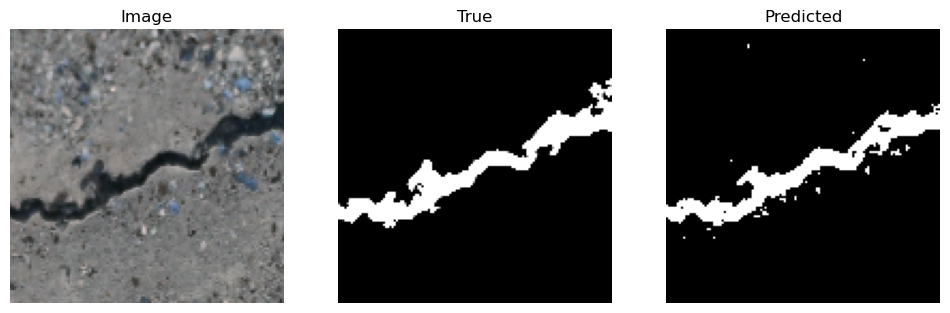

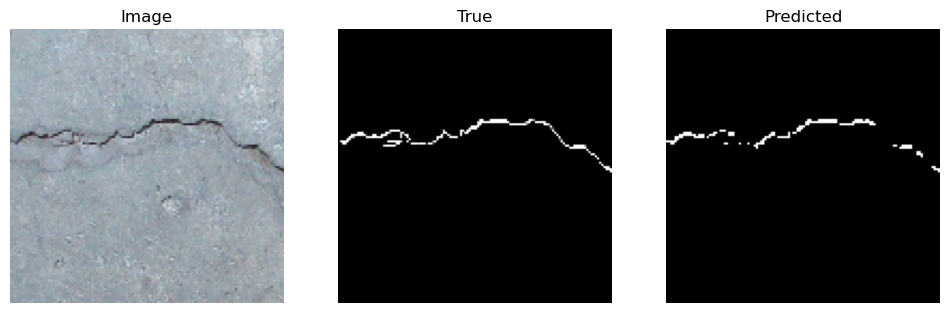

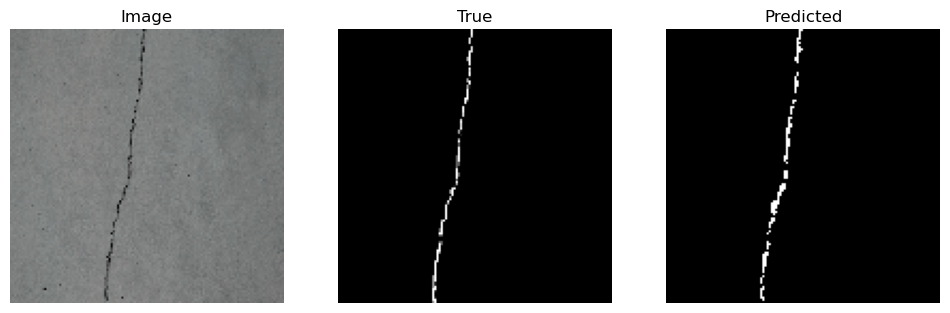

In [81]:
def visualize_prediction(idx):
    img = X_val[idx]
    true_mask = y_val[idx].squeeze()
    pred_mask = y_val_pred[idx].squeeze()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Image"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(true_mask, cmap='gray'); plt.title("True"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(pred_mask > 0.5, cmap='gray'); plt.title("Predicted"); plt.axis("off")
    plt.show()

# Visualize few predictions
for i in range(3):
    visualize_prediction(i)

In [82]:
X_test, y_test = zip(*[preprocess(i, m) for i, m in zip(test_images, test_masks)])
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

y_test_pred = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


In [83]:
get_metrics(y_test_pred)

Accuracy: 0.9798911213874817 IoU: 0.8058421015739441 F1 Score 0.7604996562004089


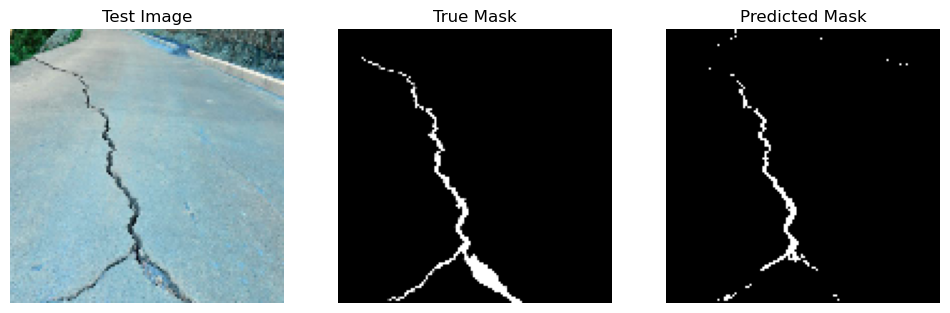

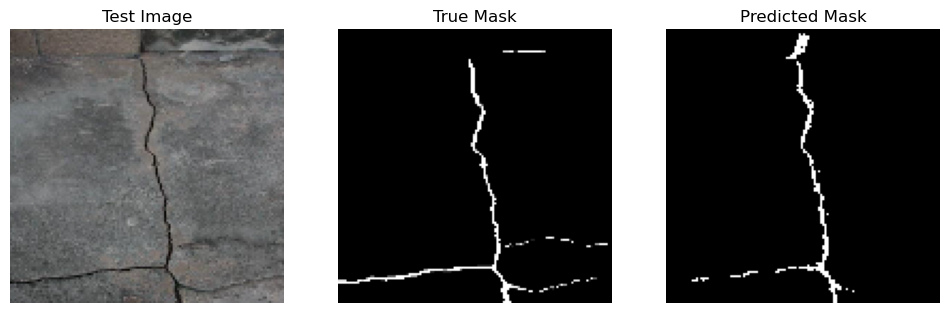

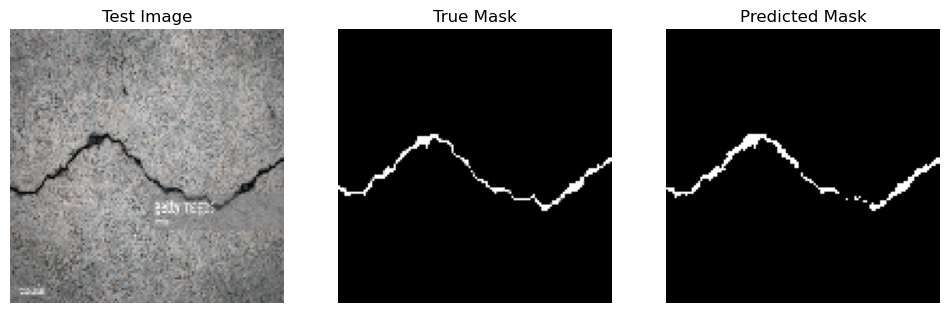

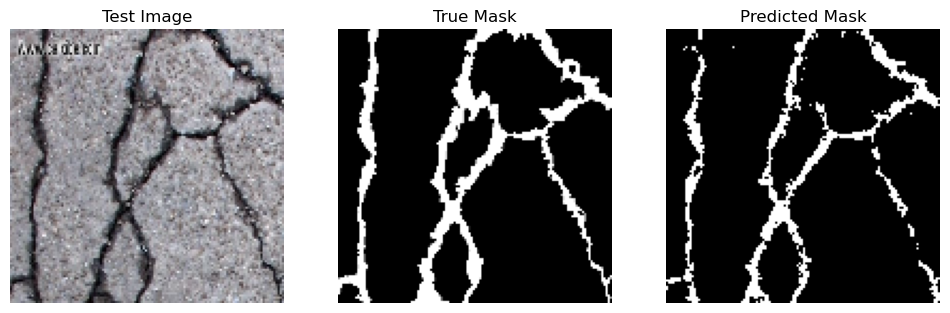

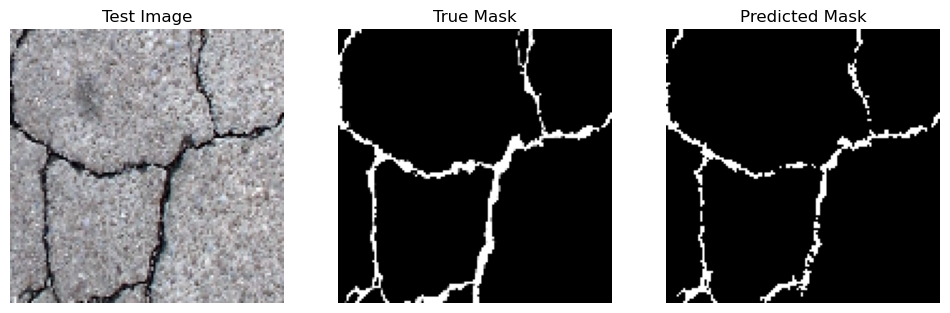

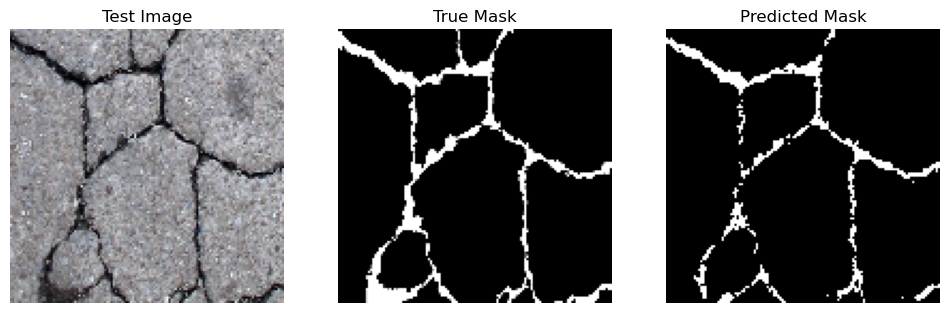

In [84]:
def visualize_test(idx):
    img = X_test[idx]
    true_mask = y_test[idx].squeeze()
    pred_mask = y_test_pred[idx].squeeze()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Test Image"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(true_mask, cmap='gray'); plt.title("True Mask"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(pred_mask > 0.5, cmap='gray'); plt.title("Predicted Mask"); plt.axis("off")
    plt.show()

for i in range(9,15):
    visualize_test(i)